# Data Exploration & Cleaning

In [3]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# load dataset
train_df = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/raw/train.csv")
eval_df = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/raw/eval.csv")
holdout_df = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/raw/holdout.csv")
metros = pd.read_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/raw/usmetros.csv")

In [6]:
print(f"Train_df shape: {train_df.shape}")
print(f"Eval_df shape: {eval_df.shape}")
print(f"Holdout_df shape: {holdout_df.shape}")
print(f"Metros shape: {metros.shape}")

Train_df shape: (585244, 39)
Eval_df shape: (149424, 39)
Holdout_df shape: (149424, 39)
Metros shape: (387, 11)


In [7]:
metros.head()

,metro_fips,metro,metro_ascii,metro_full,county_name,county_fips,state_id,state_name,lat,lng,population
0,35620,New York,New York,"New York-Newark-Jersey City, NY-NJ",Suffolk,36103,NY,New York,40.7222,-74.0225,19498249
1,31080,Los Angeles,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,6037,CA,California,34.2215,-118.1494,12799100
2,16980,Chicago,Chicago,"Chicago-Naperville-Elgin, IL-IN",Cook,17031,IL,Illinois,41.6675,-87.9597,9262559
3,19100,Dallas,Dallas,"Dallas-Fort Worth-Arlington, TX",Denton,48121,TX,Texas,32.8495,-96.9704,8100037
4,26420,Houston,Houston,"Houston-Pasadena-The Woodlands, TX",Harris,48201,TX,Texas,29.8422,-95.3855,7510252


In metros dataframe, the "metro_full" col contains metro area names concatenated with state information after a comma.
For consistency, the state information is removed by truncating each string at the first comma.

In [8]:
metros['metro_full'] = metros['metro_full'].str.split(",").str[0]

In [9]:
metros.head()

,metro_fips,metro,metro_ascii,metro_full,county_name,county_fips,state_id,state_name,lat,lng,population
0,35620,New York,New York,New York-Newark-Jersey City,Suffolk,36103,NY,New York,40.7222,-74.0225,19498249
1,31080,Los Angeles,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles,6037,CA,California,34.2215,-118.1494,12799100
2,16980,Chicago,Chicago,Chicago-Naperville-Elgin,Cook,17031,IL,Illinois,41.6675,-87.9597,9262559
3,19100,Dallas,Dallas,Dallas-Fort Worth-Arlington,Denton,48121,TX,Texas,32.8495,-96.9704,8100037
4,26420,Houston,Houston,Houston-Pasadena-The Woodlands,Harris,48201,TX,Texas,29.8422,-95.3855,7510252


In [10]:
train_df['city_full'].value_counts().head()

city_full
New York-Newark-Jersey City       78020
Chicago-Naperville-Elgin          35344
Los Angeles-Long Beach-Anaheim    33840
Philadelphia-Camden-Wilmington    31396
DC_Metro                          29516
Name: count, dtype: int64

## Map cities to longitude and latitude

In [11]:
city_mapping = {
    'Las Vegas-Henderson-Paradise': 'Las Vegas-Henderson-North Las Vegas',
    'Denver-Aurora-Lakewood': 'Denver-Aurora-Centennial',
    'Houston-The Woodlands-Sugar Land': 'Houston-Pasadena-The Woodlands',
    'Austin-Round Rock-Georgetown': 'Austin-Round Rock-San Marcos',
    'Miami-Fort Lauderdale-Pompano Beach': 'Miami-Fort Lauderdale-West Palm Beach',
    'San Francisco-Oakland-Berkeley': 'San Francisco-Oakland-Fremont',
    'DC_Metro': 'Washington-Arlington-Alexandria',
    'Atlanta-Sandy Springs-Alpharetta': 'Atlanta-Sandy Springs-Roswell'
}

In [12]:
def clean_and_merge_city(df):
    df['city_full'] = df['city_full'].replace(city_mapping)

    df = df.merge(
        metros[['metro_full', 'lat', 'lng']],
        how='left',
        left_on='city_full',
        right_on='metro_full'
    )
    df.drop(columns=['metro_full'], inplace=True)

    # Log any cities that could not be mapped
    missing = df[df['lat'].isnull()]['city_full'].unique()
    if len(missing) > 0:
        print(f"Warning: The following cities could not be mapped to lat/lng: {missing}")
    else:
        print("All cities successfully mapped to lat/lng.")
    return df

In [13]:
train_df = clean_and_merge_city(train_df)
eval_df = clean_and_merge_city(eval_df)
holdout_df = clean_and_merge_city(holdout_df)

All cities successfully mapped to lat/lng.
All cities successfully mapped to lat/lng.
All cities successfully mapped to lat/lng.


In [14]:
print(f"Train df shape after mergin: {train_df.shape}")
print(f"Eval df shape after mergin: {eval_df.shape}")
print(f"Holdout df shape after mergin: {holdout_df.shape}")

Train df shape after mergin: (585244, 41)
Eval df shape after mergin: (149424, 41)
Holdout df shape after mergin: (149424, 41)


# Clean Duplicates

The `date` and the `year` cols are excluded when identifying duplicate records because the same house can be listed multiple times at different points in time.

In [15]:
duplicate_rows = train_df[train_df.duplicated()].shape[0]
print(f"Number of duplicate rows in train_df: {duplicate_rows}")
duplicate_rows = eval_df[eval_df.duplicated()].shape[0]
print(f"Number of duplicate rows in eval_df: {duplicate_rows}")
duplicate_rows = holdout_df[holdout_df.duplicated()].shape[0]
print(f"Number of duplicate rows in holdout_df: {duplicate_rows}")


Number of duplicate rows in train_df: 0
Number of duplicate rows in eval_df: 0
Number of duplicate rows in holdout_df: 0


In [18]:
duplicate_rows_train = train_df[train_df.duplicated(subset=train_df.columns.difference(['date', 'year']))].shape[0]
print(f"Number of duplicate rows in train_df (excluding date and year): {duplicate_rows}")
duplicate_rows_eval = eval_df[eval_df.duplicated(subset=eval_df.columns.difference(['date', 'year']))].shape[0]
print(f"Number of duplicate rows in eval_df (excluding date and year): {duplicate_rows}")
duplicate_rows_holdout = holdout_df[holdout_df.duplicated(subset=holdout_df.columns.difference(['date', 'year']))].shape[0]
print(f"Number of duplicate rows in holdout_df (excluding date and year): {duplicate_rows_holdout}")

Number of duplicate rows in train_df (excluding date and year): 0
Number of duplicate rows in eval_df (excluding date and year): 0
Number of duplicate rows in holdout_df (excluding date and year): 0


In [19]:
# Remove duplicates excluding 'date' and 'year' columns
print(f"Train df shape before removing duplicates: {train_df.shape}")
print(f"Eval df shape before removing duplicates: {eval_df.shape}")
print(f"Holdout df shape before removing duplicates: {holdout_df.shape}")

train_df = train_df.drop_duplicates(subset=train_df.columns.difference(['date', 'year']), keep='first').reset_index(drop=True)
eval_df = eval_df.drop_duplicates(subset=eval_df.columns.difference(['date', 'year']), keep='first').reset_index(drop=True)
holdout_df = holdout_df.drop_duplicates(subset=holdout_df.columns.difference(['date', 'year']), keep='first').reset_index(drop=True)

print(f"Train df shape after removing duplicates: {train_df.shape}")
print(f"Eval df shape after removing duplicates: {eval_df.shape}")
print(f"Holdout df shape before removing duplicates: {holdout_df.shape}")

Train df shape before removing duplicates: (578923, 41)
Eval df shape before removing duplicates: (148698, 41)
Holdout df shape before removing duplicates: (149081, 41)
Train df shape after removing duplicates: (578923, 41)
Eval df shape after removing duplicates: (148698, 41)
Holdout df shape before removing duplicates: (149081, 41)


# Clean outliers

In [20]:
train_df['price'].describe()

count    5.789230e+05
mean     3.401244e+05
std      3.016669e+05
min      1.046432e+04
25%      1.663567e+05
50%      2.631885e+05
75%      4.154993e+05
max      6.342460e+06
Name: price, dtype: float64

In [21]:
import plotly.express as px # type: ignore
import plotly.io as pio # pyright: ignore[reportMissingImports]

pio.renderers.default = "browser"

fig = px.violin(train_df, y="median_list_price", box=True, hover_name="median_list_price")
fig.update_layout(title="Violin Plot of Median List Price")
fig.show()

In [22]:
top_1_percent = train_df.nlargest(int(0.01 * len(train_df)), 'median_list_price')
print(f"Top 1% median list prices: {top_1_percent.shape[0]}")
top_1_percent[['median_list_price']].describe()

Top 1% median list prices: 5789


,median_list_price
count,5.789000e+03
mean,3.432104e+06
std,2.280361e+07
min,1.738000e+06
25%,1.974500e+06
50%,2.395000e+06
75%,3.000000e+06
max,1.000000e+09


In [23]:
print(top_1_percent['median_list_price'].value_counts().sort_index(ascending=False))

median_list_price
999999999.0      3
50449949.5       3
27800000.0       1
19990000.0      38
15849000.0       1
15624500.0       3
15500000.0       1
13995000.0       1
13100000.0       2
12772000.0       1
12500000.0       5
11900000.0       1
11495000.0       1
10747500.0       1
10692000.0      16
10000000.0       3
9999998.0        1
9934000.0        2
9697500.0        3
9547500.0        1
9394000.0        1
9350000.0        1
9100000.0        1
8900000.0        1
8793944.0        5
8750000.0        3
8700000.0        2
8500000.0        1
8495000.0        1
8142500.0        1
8000000.0        3
7995000.0        1
7988000.0        1
7947500.0        1
7941500.0        1
7750000.0        4
7695000.0        2
7522500.0        1
7495000.0        1
7472500.0        1
7450000.0        1
7442500.0        2
7424000.0        1
7374950.0        1
7300000.0        3
7299500.0        1
7245000.0        1
7199000.0        3
7000000.0        1
6999500.0        1
6995000.0       31
6945000.0    

In [24]:
# Clean outliers above 19M in both train and eval sets
train_df = train_df[train_df['median_list_price'] <= 19_000_000].reset_index(drop=True).copy()
eval_df = eval_df[eval_df['median_list_price'] <= 19_000_000].reset_index(drop=True).copy()
holdout_df = holdout_df[holdout_df['median_list_price'] <= 19_000_000].reset_index(drop=True).copy()

In [25]:
fig = px.violin(train_df, y="median_list_price", box=True, hover_name="median_list_price")
fig.update_layout(title="Violin Plot of Median List Price")
fig.show()

In [26]:
# save cleaned datasets
train_df.to_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/cleaned_train.csv", index=False)
eval_df.to_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/cleaned_eval.csv", index=False)
holdout_df.to_csv("/Users/leduongkhoa/Regression_MachineLearning_End2End/data/processed/cleaned_holdout.csv", index=False)
print("Cleaned datasets saved.")

Cleaned datasets saved.


# Housing prices exploration

In [28]:
df = train_df

/var/folders/fg/8rvmbbb17yx485dm6p9mr06c0000gn/T/ipykernel_26593/982662814.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




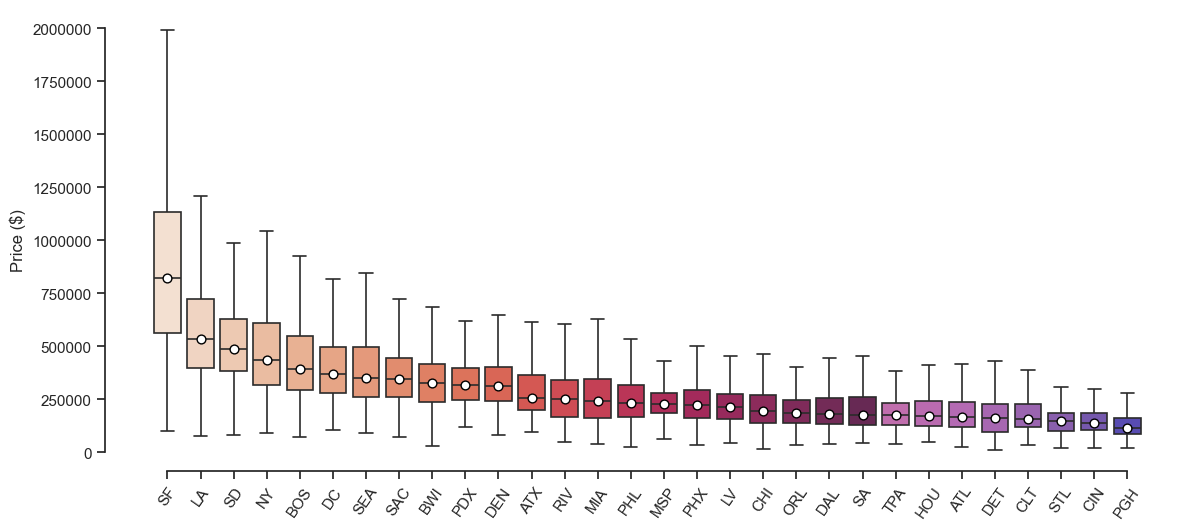

In [29]:
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt
import colorsys
sns.set_theme(style="whitegrid")           

# Boxplot of house prices for the cities, ordered by median price.

top_cities = df["city"].value_counts().head(30).index.tolist()
df_city    = df[df["city"].isin(top_cities)]
city_order = (
    df_city.groupby("city")["price"]
           .median()
           .sort_values(ascending=False)
           .index
)

base = sns.color_palette("rocket_r", len(city_order))

def lighten(color, amt=.4):
    h, l, s = colorsys.rgb_to_hls(*color)
    return colorsys.hls_to_rgb(h, min(1, l + amt*(1-l)), s)

palette = [
    lighten(c, .45) if i >= len(base) - 8 else c
    for i, c in enumerate(base)
]

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    x="city", y="price", data=df_city,
    order=city_order, palette=palette,
    showfliers=False, linewidth=1.2, ax=ax
)

medians = df_city.groupby("city")["price"].median().loc[city_order]
for tick, median in enumerate(medians):
    ax.scatter(tick, median, color="white", edgecolor="black", zorder=5, s=40)

ax.set_xlabel("")
ax.set_ylabel("Price ($)")
ax.tick_params(axis="x", rotation=55)
sns.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="y", style="plain")

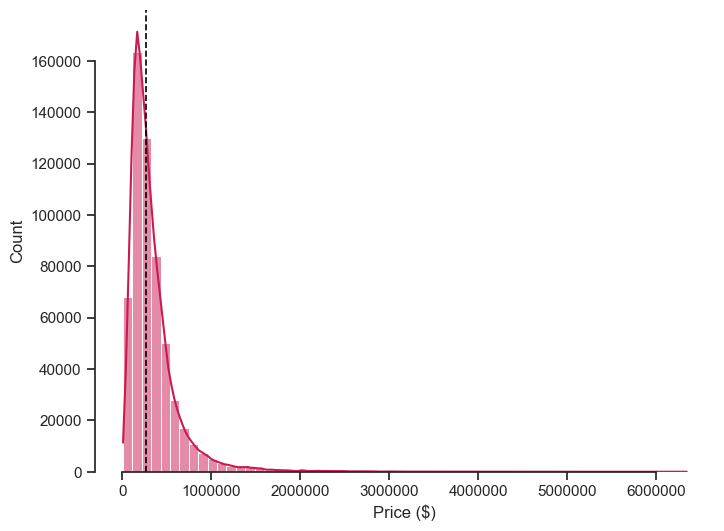

In [30]:
# Distribution of house prices across the dataset 

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df["price"].dropna(), bins=60, kde=True, color=sns.color_palette("rocket_r", 1)[0], ax=ax)
median_price = df["price"].median()
ax.axvline(median_price, ls="--", lw=1.2, color="black")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Count")
sns.despine(trim=True)
ax.grid(False)
ax.ticklabel_format(axis="x", style="plain")
plt.show()